In [1]:
import os
from pathlib import Path
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
random.seed(42)

DICT_TYPE = cv2.aruco.DICT_5X5_100

aruco_dict = cv2.aruco.getPredefinedDictionary(DICT_TYPE)
detector = cv2.aruco.ArucoDetector(aruco_dict)

board = cv2.aruco.CharucoBoard((13, 9), 0.02, 0.01, aruco_dict)
world_corners_3d = board.getChessboardCorners()


### Feature matching between 2 images

In [2]:
def feature_match_between_images(img1, img2):
    """Feature matching using ChArUco pattern."""
    
    # Detect ChArUco corners in both images
    corners, ids, _ = detector.detectMarkers(img1)
    num_corners1, corners1, ids1 = cv2.aruco.interpolateCornersCharuco(
        corners, ids, img1, board
    )
    corners, ids, _ = detector.detectMarkers(img2)
    num_corners2, corners2, ids2 = cv2.aruco.interpolateCornersCharuco(
        corners, ids, img2, board
    )
    
    # Perform matching (Find common IDs)
    good_matches = []
    matched_ids = []

    ids1 = ids1.flatten()
    ids2 = ids2.flatten()
    
    for i in range(len(ids1)):
        for j in range(len(ids2)):
            if ids1[i] == ids2[j]:
                pt1 = tuple(corners1[i][0])
                pt2 = tuple(corners2[j][0])
                good_matches.append((pt1, pt2))
                matched_ids.append(ids1[i])
                break
    
    return good_matches, matched_ids, (num_corners1, num_corners2)

In [3]:
IMAGE_DIR = Path('camera_images3')

img1 = cv2.imread(str(IMAGE_DIR / '0.jpeg'), cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(str(IMAGE_DIR / '1.jpeg'), cv2.IMREAD_GRAYSCALE)

matches, matched_ids, num_corners = feature_match_between_images(img1, img2)

print("===ChArUco detect and match result===")
print(f"image1: {num_corners[0]} corners, image2: {num_corners[1]} corners. {len(matches)} matches")

===ChArUco detect and match result===
image1: 70 corners, image2: 62 corners. 58 matches


In [4]:
def feature_match_with_charucoboard(img):
    """Feature matching using ChArUco board in a single image."""

    # Detect ChArUco corners in the image
    _corners, _ids, _ = detector.detectMarkers(img)
    num_corners, corners, ids = cv2.aruco.interpolateCornersCharuco(
        _corners, _ids, img, board
    )
    
    # Perform matching
    good_matches = []
    matched_ids = []
    
    ids = ids.flatten()
    
    for i, corner_id in enumerate(ids):
        # World coordinates (in meters, Z=0 plane)
        world_x = world_corners_3d[corner_id][0]
        world_y = world_corners_3d[corner_id][1]
        
        # Image coordinates (in pixels)
        img_u = corners[i][0][0]
        img_v = corners[i][0][1]
        
        # Store as ((world_x, world_y), (img_u, img_v))
        good_matches.append(((world_x, world_y), (img_u, img_v)))
        matched_ids.append(corner_id)
    
    return good_matches, matched_ids, num_corners

matches, matched_ids, num_corners = feature_match_with_charucoboard(img2)
print("===ChArUco detect and match result===")
print(f"image2: {num_corners} corners. {len(matches)} matches with ChArUco board")

===ChArUco detect and match result===
image2: 62 corners. 62 matches with ChArUco board


### Homography estimation (with and w/o RANSAC)
We compared the performance (reprojection error) with and without RANSAC algorithm.

In [5]:
def compute_homography(matches):
    A = []
    for (x, y), (xp, yp) in matches:
        A.append([-x, -y, -1, 0, 0, 0, x*xp, y*xp, xp])
        A.append([0, 0, 0, -x, -y, -1, x*yp, y*yp, yp])
    A = np.array(A)

    # SVD
    U, S, Vt = np.linalg.svd(A)
    h = Vt[-1, :]
    H = h.reshape(3, 3)
    return H / H[2, 2]

def average_reprojection_error(matches, H):
    total_error = 0
    for (x, y), (xp, yp) in matches:
        p = np.array([x, y, 1.0])
        projected = H @ p
        projected /= projected[2]
        error = np.linalg.norm(projected[:2] - np.array([xp, yp]))
        total_error += error
    return total_error / len(matches)

def ransac_homography(matches, threshold=3.0, iterations=1000):
    best_H = None
    max_inliers = 0
    best_inliers = []

    for _ in range(iterations):
        sample = random.sample(matches, 4)
        H_candidate = compute_homography(sample)
        inliers = []

        for (x, y), (xp, yp) in matches:
            p = np.array([x, y, 1.0])
            projected = H_candidate @ p
            projected /= projected[2]
            error = np.linalg.norm(projected[:2] - np.array([xp, yp]))
            if error < threshold:
                inliers.append(((x, y), (xp, yp)))

        if len(inliers) > max_inliers:
            max_inliers = len(inliers)
            best_H = H_candidate
            best_inliers = inliers

    return best_H / best_H[2,2], best_inliers

matches, matched_ids, num_corners = feature_match_between_images(img1, img2)

H = compute_homography(matches)
error = average_reprojection_error(matches, H)
print(f"Average Reprojection Error: {error:.4f} pixels")

H_ransac, inlier_matches = ransac_homography(matches, threshold=5.0, iterations=1000)
print(H_ransac)
error = average_reprojection_error(inlier_matches, H_ransac)

print(f"RANSAC Homography Inliers: {len(inlier_matches)} / {len(matches)}")
print(f"Average Reprojection Error after RANSAC: {error:.4f} pixels")

Average Reprojection Error: 1.2662 pixels
[[ 1.16738176e+00  1.99303281e-02  1.78755423e+01]
 [ 3.79453680e-02  1.12135268e+00 -7.53301557e+01]
 [ 4.36747663e-05  4.28399735e-06  1.00000000e+00]]
RANSAC Homography Inliers: 58 / 58
Average Reprojection Error after RANSAC: 1.4353 pixels


### Main Pipeline
1. Feature Matching with charuco board (world coordinates)
2. Homography Estimation (with **RANSAC**) for all images
3. Compuatation of camera parameters: intrinsics, extrinsics

In [6]:
filenames = sorted(os.listdir(IMAGE_DIR), key=lambda x: int(x.split('.')[0]))
H_list = []

for i in range(0, len(filenames)):
    img_path =str(IMAGE_DIR / filenames[i])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    matches, _, _ = feature_match_with_charucoboard(img)

    H_ransac, inlier_matches = ransac_homography(matches, threshold=5.0, iterations=1000)
    print(H_ransac)
    error = average_reprojection_error(inlier_matches, H_ransac)

    H_list.append(H_ransac)

    print(f"=== Image {i} ===")
    print(f"Matches: {len(matches)}, Inliers: {len(inlier_matches)} / {len(matches)}")
    print(f"Average Reprojection Error: {error:.4f} pixels\n")

[[-8.21546830e+03 -4.64973250e+02  2.54830129e+03]
 [-1.79273051e+01 -8.40468058e+03  2.17261687e+03]
 [-8.33740295e-02 -2.34470828e-01  1.00000000e+00]]
=== Image 0 ===
Matches: 70, Inliers: 65 / 70
Average Reprojection Error: 2.9274 pixels

[[-8.50948464e+03 -6.15074883e+02  2.71221569e+03]
 [-2.19796634e+02 -8.43281319e+03  2.19480594e+03]
 [-3.50977505e-01 -2.44805784e-01  1.00000000e+00]]
=== Image 1 ===
Matches: 62, Inliers: 52 / 62
Average Reprojection Error: 2.6281 pixels

[[-7.82956167e+03 -4.66448292e+02  2.67418863e+03]
 [-1.40019060e+03 -7.30901135e+03  2.03615419e+03]
 [-1.14929018e+00 -2.33485031e-01  1.00000000e+00]]
=== Image 2 ===
Matches: 42, Inliers: 34 / 42
Average Reprojection Error: 2.7558 pixels

[[-7.38096824e+03 -5.25460852e+02  2.43755386e+03]
 [ 1.43960104e+03 -9.57047052e+03  2.28939367e+03]
 [ 9.90119626e-01 -2.71026519e-01  1.00000000e+00]]
=== Image 3 ===
Matches: 70, Inliers: 64 / 70
Average Reprojection Error: 2.8105 pixels

[[-6.01482136e+03 -9.6602600

In [7]:
def compute_v_ij(H, i, j):
    return np.array([
        H[0, i]*H[0, j],
        H[0, i]*H[1, j] + H[1, i]*H[0, j],
        H[1, i]*H[1, j],
        H[2, i]*H[0, j] + H[0, i]*H[2, j],
        H[2, i]*H[1, j] + H[1, i]*H[2, j],
        H[2, i]*H[2, j]
    ])

def estimate_intrinsics(H_list):
    
    V = []
    for H in H_list:
        v12 = compute_v_ij(H, 0, 1)
        v11 = compute_v_ij(H, 0, 0)
        v22 = compute_v_ij(H, 1, 1)
        V.append(v12)
        V.append(v11 - v22)
    V = np.array(V)

    # Solve Vb = 0 using SVD
    _, _, Vt = np.linalg.svd(V)
    b = Vt[-1, :]

    # Extract parameters from b
    B11, B12, B22, B13, B23, B33 = b
    v0 = (B12*B13 - B11*B23) / (B11*B22 - B12**2)
    lam = B33 - (B13**2 + v0*(B12*B13 - B11*B23)) / B11
    alpha = np.sqrt(lam / B11)
    beta = np.sqrt(lam * B11 / (B11*B22 - B12**2))
    gamma = -B12 * alpha**2 * beta / lam
    u0 = gamma * v0 / beta - B13 * alpha**2 / lam

    # Construct K matrix
    K = np.array([
        [alpha, gamma, u0],
        [0,     beta,  v0],
        [0,     0,     1]
    ])
    return K

def estimate_extrinsics(H, K):
    K_inv = np.linalg.inv(K)
    h1 = H[:, 0]
    h2 = H[:, 1]
    h3 = H[:, 2]

    lambda_ = 1.0 / np.linalg.norm(K_inv @ h1)
    r1 = lambda_ * (K_inv @ h1)
    r2 = lambda_ * (K_inv @ h2)
    r3 = np.cross(r1, r2)
    t = lambda_ * (K_inv @ h3)

    # Ensure R is a valid rotation matrix using orthonormalization (SVD)
    R = np.stack([r1, r2, r3], axis=1)
    U, _, Vt = np.linalg.svd(R)
    R_orthonormal = U @ Vt

    return R_orthonormal, t

K = estimate_intrinsics(H_list)
print("Estimated Intrinsic Matrix K:\n\n", K)

extrinsics = []

# Append the extrinsics for the other cameras
for idx, H in enumerate(H_list):
    R, t = estimate_extrinsics(H, K)
    print(f"=== Image {idx} ===")
    print("Rotation Matrix R:\n", R)
    print("Translation Vector t:\n", t)
    print()
    extrinsics.append((R, t))

Estimated Intrinsic Matrix K:

 [[ 2.93561947e+03 -1.88895670e+00  1.44782227e+03]
 [ 0.00000000e+00  2.92127598e+03  1.52264651e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
=== Image 0 ===
Rotation Matrix R:
 [[-0.99942006 -0.01351676 -0.03125452]
 [ 0.01610986 -0.99631335 -0.08426259]
 [-0.03000034 -0.08471723  0.9959533 ]]
Translation Vector t:
 [0.13592814 0.08064594 0.3624612 ]

=== Image 1 ===
Rotation Matrix R:
 [[-0.99098108 -0.0303716  -0.13051464]
 [ 0.04149521 -0.99565413 -0.08337268]
 [-0.12741528 -0.08803648  0.98793468]]
Translation Vector t:
 [0.15666632 0.08366496 0.36361677]

=== Image 2 ===
Rotation Matrix R:
 [[-0.87607685 -0.0129283  -0.48199814]
 [ 0.05675079 -0.9954571  -0.07644943]
 [-0.47882011 -0.09432935  0.87283061]]
Translation Vector t:
 [0.17432299 0.07333157 0.41717343]

=== Image 3 ===
Rotation Matrix R:
 [[-0.94972311 -0.01759064  0.31259653]
 [-0.01002045 -0.99620121 -0.08650278]
 [ 0.31293068 -0.08528605  0.94593905]]
Translation Vector t:

### Visualize the result

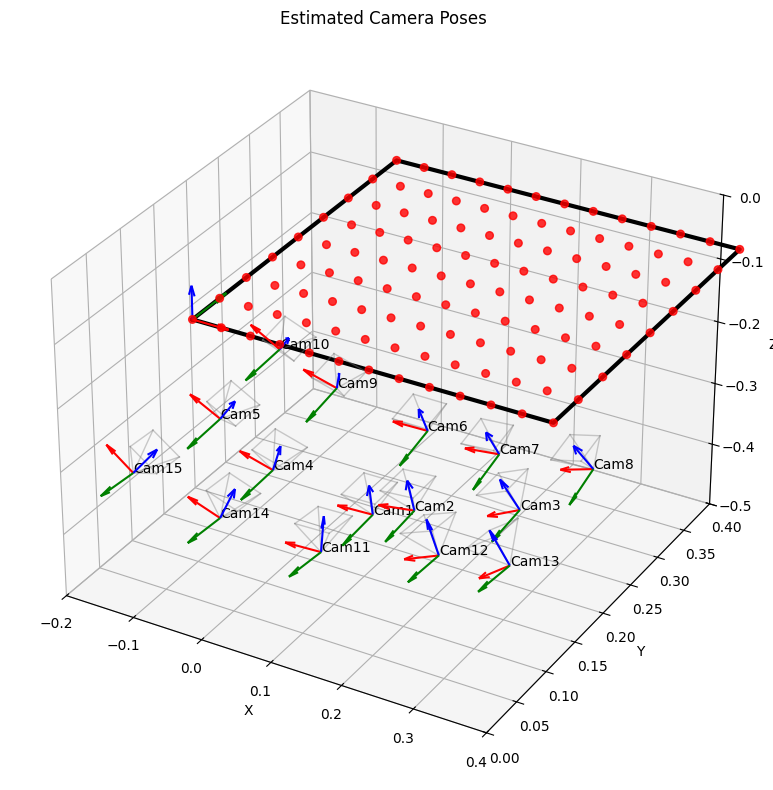

In [10]:
from mpl_toolkits.mplot3d import Axes3D

def plot_camera_frustum(ax, R, camera_center, scale):
    """
    Visualize the camera frustum (field of view).
    """
    l, w, h = scale * 1.5, scale * 0.8, scale * 0.6
    
    # Frustum corner points in camera coordinates
    frustum_points_local = np.array([
        [0, 0, 0],  # Camera center
        [-w, -h, l],
        [ w, -h, l],
        [ w,  h, l],
        [-w,  h, l]
    ])
    
    # Transform to world coordinates
    frustum_points_world = []
    for point in frustum_points_local:
        world_point = R @ point + camera_center
        frustum_points_world.append(world_point)
    
    frustum_points_world = np.array(frustum_points_world)
    
    # Draw lines from camera center to each corner and between corners
    for i in range(1, 5):
        ax.plot(
            [frustum_points_world[0, 0], frustum_points_world[i, 0]],
            [frustum_points_world[0, 1], frustum_points_world[i, 1]],
            [frustum_points_world[0, 2], frustum_points_world[i, 2]], 
            color='gray', alpha=0.4, linewidth=1
        )
        next_i = i + 1 if i < 4 else 1
        ax.plot(
            [frustum_points_world[i, 0], frustum_points_world[next_i, 0]],
            [frustum_points_world[i, 1], frustum_points_world[next_i, 1]],
            [frustum_points_world[i, 2], frustum_points_world[next_i, 2]], 
             color='gray', alpha=0.4, linewidth=1
        )
    
def plot_camera_poses(extrinsics):
    """
    Visualize camera extrinsics and ChArUco board in 3D space.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Draw ChArUco board corners
    squares_x, squares_y = 13, 9
    square_length = 0.04

    x_coords, y_coords = np.meshgrid(
        np.arange(squares_x) * square_length,
        np.arange(squares_y) * square_length
    )
    z_coords = np.zeros_like(x_coords.flatten())
    
    ax.scatter(x_coords.flatten(), y_coords.flatten(), z_coords, c='red', s=30, alpha=0.8)
    
    # Draw board boundary
    max_x = (squares_x - 1) * square_length
    max_y = (squares_y - 1) * square_length
    boundary_x = [0, max_x, max_x, 0, 0]
    boundary_y = [0, 0, max_y, max_y, 0]
    boundary_z = [0, 0, 0, 0, 0]
    ax.plot(boundary_x, boundary_y, boundary_z, 'k-', linewidth=3)

    # Draw world coordinate axes
    ax.quiver(0, 0, 0, 0.1, 0, 0, color='r', length=0.5)
    ax.quiver(0, 0, 0, 0, 0.1, 0, color='g', length=0.5)
    ax.quiver(0, 0, 0, 0, 0, 0.1, color='b', length=0.5)

    for idx, (R, t) in enumerate(extrinsics):
        # Camera center in world coordinates
        C = -R.T @ t

        # Draw camera axes
        cam_axis = R.T
        ax.quiver(C[0], C[1], C[2], cam_axis[0, 0], cam_axis[1, 0], cam_axis[2, 0], color='r', length=0.05)
        ax.quiver(C[0], C[1], C[2], cam_axis[0, 1], cam_axis[1, 1], cam_axis[2, 1], color='g', length=0.05)
        ax.quiver(C[0], C[1], C[2], cam_axis[0, 2], cam_axis[1, 2], cam_axis[2, 2], color='b', length=0.05)

        ax.text(C[0], C[1], C[2], f"Cam{idx+1}", color='black')

        plot_camera_frustum(ax, R, C, scale=0.03)

    # Set axis limits (centered on chessboard)
    ax.set_xlim(-0.2, 0.4)
    ax.set_ylim(0.0, 0.4)
    ax.set_zlim(-0.5, 0.0)

    ax.set_title("Estimated Camera Poses")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.view_init(elev=30, azim=-60)
    plt.tight_layout()
    plt.show()

plot_camera_poses(extrinsics)